### Problem List: 50, 16, 26, 51, 59

# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [2]:
import os
import cv2
import csv
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats

from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, concatenate, SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TerminateOnNaN, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l1, l1_l2
from tensorflow.keras import regularizers

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt

In [3]:
seed_value = 10 # original

# seed_value = 0 #[RandomSeed]
# seed_value = 20
# seed_value = 42 
# seed_value = 64
# seed_value = 100
# seed_value = 123
# seed_value = 200
# seed_value = 456
# seed_value = 1001
# seed_value = 12321


os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU setting

In [4]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [6]:
KeypointsROOT = "../../4_Cut_Video/data/"

n_FEATURE = 13
n_PERIOD = 25

n_FOLD = 5
n_MODEL = 3

isPadding = False
isDownsampling = True

In [7]:
allID_list = []

Label_dict = {}
pid_dict = {}

frameNum_dict = {}

result_dict_combined = {}

# remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
# remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

In [8]:
# DATE = "20240620"
DATE = "20240821"


flag_MMSE = False
flag_MMSE_Scaled = False
flag_CDR = False
flag_CDR_Scaled = False
flag_CDRSOB = True
flag_CDRSOB_Scaled = False

flag_PreTrained = True

In [9]:
if flag_PreTrained==False:
    if flag_MMSE: 
        SAVEMODEL_FOLDER = "LOG_SitStand/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVEMODEL_FOLDER = "LOG_SitStand/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVEMODEL_FOLDER = "LOG_SitStand/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
if flag_PreTrained==True:
    if flag_MMSE: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        SAVEMODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"


print(f'Save model weights to FOLDER: {SAVEMODEL_FOLDER}')

Save model weights to FOLDER: LOG_SitStand_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


# Load Label

In [10]:
excel_path = "../Label_Data_Info.xlsx" 

df_label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label'])
df_label = df_label.fillna(0)
df_label = df_label.astype({"_Label": int})

Label_arr = np.array(df_label['_Label'])
Label_dict = dict(zip(df_label.編號, df_label._Label))

print(f'Number of subjects in Label_dict: {len(Label_dict)} subjects.\n')
print(f'Label_dict:\n{Label_dict}')

Number of subjects in Label_dict: 100 subjects.

Label_dict:
{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


In [11]:
def check_data_distribution(KeypointsROOT):
    labelList = []
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        label = Label_dict[int(folder)] 
        labelList.append(label)
    lableArray = np.array(labelList)
    print(f'Data we have ...')
    print(f'# of AD pid: {np.count_nonzero(lableArray == 1)}')
    print(f'# of NC pid: {np.count_nonzero(lableArray == 0)}\n')
    print(f'Ratio (all guess Positive): {round(np.count_nonzero(lableArray == 1)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    print(f'Ratio (all guess Negative): {round(np.count_nonzero(lableArray == 0)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')

check_data_distribution(KeypointsROOT)

Data we have ...
# of AD pid: 30
# of NC pid: 58

Ratio (all guess Positive): 0.3409
Ratio (all guess Negative): 0.6591


# Load MMSE/CDR/CDRSOB score

In [12]:
excel_path = "../Score_Data_Info.xlsx"

df_MMSE = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'MMSE/總分30'])
df_MMSE = df_MMSE.fillna(0)
df_MMSE = df_MMSE.astype({"MMSE/總分30": int})
df_MMSE = df_MMSE.rename(columns={'MMSE/總分30': 'MMSE'})
MMSE_dict = dict(zip(df_MMSE.編號, df_MMSE.MMSE))

df_CDR = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDR'])
df_CDR = df_CDR.fillna(0)
df_CDR = df_CDR.astype({"my_CDR": float})
df_CDR = df_CDR.rename(columns={'my_CDR': 'CDR'})
CDR_dict = dict(zip(df_CDR.編號, df_CDR.CDR))

df_CDRSOB = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDRSOB'])
df_CDRSOB = df_CDRSOB.fillna(0)
df_CDRSOB = df_CDRSOB.astype({"my_CDRSOB": float})
df_CDRSOB = df_CDRSOB.rename(columns={'my_CDRSOB': 'CDRSOB'})
CDRSOB_dict = dict(zip(df_CDRSOB.編號, df_CDRSOB.CDRSOB))

print(CDRSOB_dict)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 1.5, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 6.0, 10: 1.0, 11: 9.0, 12: 1.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 3.0, 17: 1.0, 18: 1.5, 19: 2.5, 20: 3.0, 21: 0.0, 22: 0.0, 23: 6.0, 24: 1.5, 25: 3.0, 26: 1.0, 27: 4.0, 28: 0.5, 29: 0.0, 30: 0.0, 31: 1.0, 32: 2.0, 33: 8.0, 34: 0.0, 35: 2.5, 36: 8.0, 37: 1.5, 38: 0.5, 39: 2.0, 40: 1.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 1.5, 46: 0.0, 47: 0.0, 48: 2.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 5.0, 61: 1.5, 62: 4.0, 63: 2.5, 64: 5.0, 65: 1.0, 66: 4.5, 67: 0.5, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0}


# Normalize Score

In [13]:
MMSE_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_MMSE_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = MMSE_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

MMSE_dict_scaled = normalize_MMSE_score(MMSE_dict)

In [14]:
CDR_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDR_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDR_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDR_dict_scaled = normalize_CDR_score(CDR_dict)

In [15]:
CDRSOB_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDRSOB_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDRSOB_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDRSOB_dict_scaled = normalize_CDRSOB_score(CDRSOB_dict)
print(CDRSOB_dict_scaled)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.16666666666666666, 5: 0.1111111111111111, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.6666666666666666, 10: 0.1111111111111111, 11: 1.0, 12: 0.1111111111111111, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.3333333333333333, 17: 0.1111111111111111, 18: 0.16666666666666666, 19: 0.2777777777777778, 20: 0.3333333333333333, 21: 0.0, 22: 0.0, 23: 0.6666666666666666, 24: 0.16666666666666666, 25: 0.3333333333333333, 26: 0.1111111111111111, 27: 0.4444444444444444, 28: 0.05555555555555555, 29: 0.0, 30: 0.0, 31: 0.1111111111111111, 32: 0.2222222222222222, 33: 0.8888888888888888, 34: 0.0, 35: 0.2777777777777778, 36: 0.8888888888888888, 37: 0.16666666666666666, 38: 0.05555555555555555, 39: 0.2222222222222222, 40: 0.1111111111111111, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.16666666666666666, 46: 0.0, 47: 0.0, 48: 0.2222222222222222, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.1111111111111111, 58: 0.1111111111111111, 59: 0.1111111111111111, 60: 0.55555555555555

# Load Subject ID

In [16]:
def pid_mapping():
    tmp_list = []
    data_dict = {}
    
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        pid = int(folder)
        data_dict[pid] = folder
        tmp_list.append(folder)
    return data_dict, tmp_list

pid_dict, allID_list = pid_mapping()

print(f'pid_dict:\n{pid_dict}\n')

print(f'[Info] number of subjects: {len(allID_list)} subjects.')
print(f'allID_list:\n{allID_list}')

pid_dict:
{1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 9: '09', 10: '10', 100: '100', 11: '11', 12: '12', 13: '13', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 43: '43', 44: '44', 45: '45', 46: '46', 48: '48', 49: '49', 51: '51', 52: '52', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 85: '85', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99'}

[Info] number of subjects: 88 subjects.
allID_list:
['01', '02', '03', '04', '05', '06', '07', '09', '10', '100', 

# Split Subject ID (5-Fold)

In [17]:
def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/sitstand_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/sitstand_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/sitstand_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f


trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'-Train: (num: {len(trainID_5f[i])})\n{trainID_5f[i]}')
    print(f'-Validate: (num: {len(validateID_5f[i])})\n{validateID_5f[i]}')
    print(f'-Test: (num: {len(testID_5f[i])})\n{testID_5f[i]}\n')    

[Fold 1] Total: 88 subjects.
-Train: (num: 56)
['17', '18', '20', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '43', '46', '48', '51', '52', '57', '58', '60', '61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '85', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
-Validate: (num: 14)
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
-Test: (num: 18)
['01', '02', '04', '11', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 88 subjects.
-Train: (num: 56)
['17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '44', '45', '46', '48', '49', '51', '57', '58', '59', '60', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '83', '84', '85', '86', '88', '89', '92', '94', '95', '97', '98', '99'

In [18]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [19]:
def check_sitstand_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')
    
check_sitstand_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 88 subjects.

[Info] Check for each fold ...
 -fold 1: 88 subjects.
 -fold 2: 88 subjects.
 -fold 3: 88 subjects.
 -fold 4: 88 subjects.
 -fold 5: 88 subjects.


# Load frame number

In [20]:
def countFrames(KeypointsROOT, pidList, flag1, flag2):
    tmp_dict = {}
    for pid in pidList:
        if pid == "01":
            if flag1==True and flag2==False:
                csv_path1 = KeypointsROOT + pid + '/_yolo/Sit_and_Stand/timeSeries_Data_Sit2Stand_padding.csv'
                csv_path2 = KeypointsROOT + pid + '/_yolo/Sit_and_Stand/timeSeries_Data_Stand2Sit_padding.csv'

                if not os.path.exists(csv_path1) or not os.path.exists(csv_path2):
                    print(f'[pid {pid}] CSV does not exit.')
                else:
                    df1 = pd.read_csv(csv_path1, header=None)
                    df2 = pd.read_csv(csv_path2, header=None)
                    n_row1, n_col1 = df1.shape[0], df1.shape[1]
                    n_row2, n_col2 = df2.shape[0], df2.shape[1]

                    tmp_dict["Sit-to-Stand"] = {}
                    tmp_dict["Sit-to-Stand"]["max"] = n_row1
                    tmp_dict["Stand-to-Sit"] = {}
                    tmp_dict["Stand-to-Sit"]["max"] = n_row2
            elif flag1==False and flag2==True:
                csv_path1 = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_sit2stand_timeSeries_resampling.csv'
                csv_path2 = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_stand2sit_timeSeries_resampling.csv'

                if not os.path.exists(csv_path1) or not os.path.exists(csv_path2):
                    print(f'[pid {pid}] CSV does not exit.')
                else:
                    df1 = pd.read_csv(csv_path1, header=None)
                    df2 = pd.read_csv(csv_path2, header=None)
                    n_feature1, n_timestamp1 = df1.shape[0], df1.shape[1]
                    n_feature2, n_timestamp2 = df2.shape[0], df2.shape[1]

                    tmp_dict["Sit-to-Stand"] = {}
                    tmp_dict["Sit-to-Stand"]["min"] = n_timestamp1
                    tmp_dict["Stand-to-Sit"] = {}
                    tmp_dict["Stand-to-Sit"]["min"] = n_timestamp2
            else:
                print(f'[Info] check flags: isPadding & isDownsampling.')
    return tmp_dict


frameNum_dict = countFrames(KeypointsROOT, allID_list, isPadding, isDownsampling)

print(frameNum_dict)

{'Sit-to-Stand': {'min': 25}, 'Stand-to-Sit': {'min': 29}}


# Sit-to-Stand

## Load Coordinate Data

In [21]:
def load_coordinate_data(trainID, valID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxVal_5f, xVal_5f, yVal_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []
    
    for fold_idx in range(n_FOLD):
        idxTrain, xTrain, yTrain = [], [], []
        idxVal, xVal, yVal = [], [], []
        idxTest, xTest, yTest = [], [], []

        train_index = trainID[fold_idx]
        val_index = valID[fold_idx]
        test_index = testID[fold_idx]

        for pid in train_index: ### ===================================== Train =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_sit2stand_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]
                idxTrain.append(int(pid))
                xTrain.append(xData)
                yTrain.append(yLabel)
        
        for pid in val_index: ### ===================================== Validation =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_sit2stand_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]
                idxVal.append(int(pid))
                xVal.append(xData)
                yVal.append(yLabel)
        
        for pid in test_index: ### ===================================== Test =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_sit2stand_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]
                idxTest.append(int(pid))
                xTest.append(xData)
                yTest.append(yLabel)

        idxTrain_5f.append(np.array(idxTrain))
        xTrain_5f.append(np.array(xTrain))
        yTrain_5f.append(np.array(yTrain))
        idxVal_5f.append(np.array(idxVal))
        xVal_5f.append(np.array(xVal))
        yVal_5f.append(np.array(yVal))
        idxTest_5f.append(np.array(idxTest))
        xTest_5f.append(np.array(xTest))
        yTest_5f.append(np.array(yTest))
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxVal_5f, xVal_5f, yVal_5f, idxTest_5f, xTest_5f, yTest_5f


idxTrain_5f_Sit2Stand, xTrain_5f_Sit2Stand, yTrain_5f_Sit2Stand, \
    idxVal_5f_Sit2Stand, xVal_5f_Sit2Stand, yVal_5f_Sit2Stand, \
        idxTest_5f_Sit2Stand, xTest_5f_Sit2Stand, yTest_5f_Sit2Stand = load_coordinate_data(trainID_5f, validateID_5f, testID_5f)

In [22]:
print(f'-------------------- Sit-to-Stand --------------------')
for fold_idx in range(n_FOLD):
    idxTest_5f_Sit2Stand[fold_idx] = np.array(idxTest_5f_Sit2Stand[fold_idx])
    xTest_5f_Sit2Stand[fold_idx] = np.array(xTest_5f_Sit2Stand[fold_idx])
    yTest_5f_Sit2Stand[fold_idx] = np.array(yTest_5f_Sit2Stand[fold_idx])
    print(f'- [Fold {fold_idx+1}] idxTest: {idxTest_5f_Sit2Stand[fold_idx].shape}, xTest: {xTest_5f_Sit2Stand[fold_idx].shape}, yTest: {yTest_5f_Sit2Stand[fold_idx].shape}')

-------------------- Sit-to-Stand --------------------
- [Fold 1] idxTest: (18,), xTest: (18, 13, 25), yTest: (18,)
- [Fold 2] idxTest: (18,), xTest: (18, 13, 25), yTest: (18,)
- [Fold 3] idxTest: (18,), xTest: (18, 13, 25), yTest: (18,)
- [Fold 4] idxTest: (17,), xTest: (17, 13, 25), yTest: (17,)
- [Fold 5] idxTest: (17,), xTest: (17, 13, 25), yTest: (17,)


In [23]:
for i in range(n_FOLD):
    ### ========================= [Sit2Stand] Train =========================
    tmpIdx = np.array(idxTrain_5f_Sit2Stand[i])
    tmpX = np.array(xTrain_5f_Sit2Stand[i])
    tmpY = np.array(yTrain_5f_Sit2Stand[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxTrain_5f_Sit2Stand[i] = tmpIdx
    xTrain_5f_Sit2Stand[i] = tmpX
    yTrain_5f_Sit2Stand[i] = tmpY
    
    ### ========================= [Sit2Stand] Validate =========================
    tmpIdx = np.array(idxVal_5f_Sit2Stand[i])
    tmpX = np.array(xVal_5f_Sit2Stand[i])
    tmpY = np.array(yVal_5f_Sit2Stand[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxVal_5f_Sit2Stand[i] = tmpIdx
    xVal_5f_Sit2Stand[i] = tmpX
    yVal_5f_Sit2Stand[i] = tmpY
    
    ### ========================= [Sit2Stand] Test =========================
    tmpIdx = np.array(idxTest_5f_Sit2Stand[i])
    tmpX = np.array(xTest_5f_Sit2Stand[i])
    tmpY = np.array(yTest_5f_Sit2Stand[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxTest_5f_Sit2Stand[i] = tmpIdx
    xTest_5f_Sit2Stand[i] = tmpX
    yTest_5f_Sit2Stand[i] = tmpY


print(f'-------------------- Sit-to-Stand --------------------')
print(f'[Input Data] / [Target Data]')
for i in range(n_FOLD):
    print(f'- [Fold {i+1}] Train: {xTrain_5f_Sit2Stand[i].shape},  {yTrain_5f_Sit2Stand[i].shape}')
    print(f'-          Val:   {xVal_5f_Sit2Stand[i].shape},  {yVal_5f_Sit2Stand[i].shape}')
    print(f'-          Test:  {xTest_5f_Sit2Stand[i].shape},  {yTest_5f_Sit2Stand[i].shape}')

-------------------- Sit-to-Stand --------------------
[Input Data] / [Target Data]
- [Fold 1] Train: (56, 13, 25),  (56,)
-          Val:   (14, 13, 25),  (14,)
-          Test:  (18, 13, 25),  (18,)
- [Fold 2] Train: (56, 13, 25),  (56,)
-          Val:   (14, 13, 25),  (14,)
-          Test:  (18, 13, 25),  (18,)
- [Fold 3] Train: (56, 13, 25),  (56,)
-          Val:   (14, 13, 25),  (14,)
-          Test:  (18, 13, 25),  (18,)
- [Fold 4] Train: (56, 13, 25),  (56,)
-          Val:   (15, 13, 25),  (15,)
-          Test:  (17, 13, 25),  (17,)
- [Fold 5] Train: (56, 13, 25),  (56,)
-          Val:   (15, 13, 25),  (15,)
-          Test:  (17, 13, 25),  (17,)


In [24]:
# for i in range(n_FOLD):
#     tmpY = np.array(yTrain_5f_Sit2Stand[i])
#     print(f'- [Fold {i+1}] Train:    (AD Pair): {np.count_nonzero(tmpY==1)}, (NC Pair): {np.count_nonzero(tmpY==0)}')
#     tmpY = np.array(yVal_5f_Sit2Stand[i])
#     print(f'-          Validate: (AD Pair):  {np.count_nonzero(tmpY==1)}, (NC Pair): {np.count_nonzero(tmpY==0)}')
#     tmpY = np.array(yTest_5f_Sit2Stand[i])
#     print(f'-          Test:     (AD Pair):  {np.count_nonzero(tmpY==1)}, (NC Pair): {np.count_nonzero(tmpY==0)}')

## Training

### Train & Save models

In [25]:
n_PERIOD = 25
n_MODEL = 3

MAX_EPOCHS = 20
BATCH_SIZE = 4

# MAX_EPOCHS = 30 ### CDR, CDRSOB
# BATCH_SIZE = 8

# MAX_EPOCHS = 20
# BATCH_SIZE = 8


Threshold = 0.5

best_threshold_5f_sit2stand_List = []
best_f1score_5f_sit2stand_List = []

In [26]:
best_threshold_5f_List_Sit2Stand = []
best_f1score_5f_List_Sit2Stand = []

def show_training_loss_and_accuracy(history):
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Training accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.legend()
    plt.show()


def training_model_Validation_data_Save_model():
    idxTrain_5f, xTrain_5f, yTrain_5f = idxTrain_5f_Sit2Stand, xTrain_5f_Sit2Stand, yTrain_5f_Sit2Stand
    idxVal_5f, xVal_5f, yVal_5f = idxVal_5f_Sit2Stand, xVal_5f_Sit2Stand, yVal_5f_Sit2Stand
    
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxVal_5f[fold_idx], xVal_5f[fold_idx], yVal_5f[fold_idx]

        xTrain_1f = xTrain_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) ### shape = (n_samples, 13, 6, 1)
        xVal_1f = xVal_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)

        print(f'[Sit-to-Stand] Training for [Fold {fold_idx+1}] ...')
        # model = build_model_structure()

        if flag_PreTrained==False:
            model = Sequential()
            model.add(Conv2D(2, kernel_size=(1, 4), activation='relu', strides=1, padding='SAME', input_shape=(int(n_FEATURE), int(n_PERIOD), 1), name='first_conv')) ### grayscale image
            model.add(Conv2D(2, kernel_size=(1, 4), activation='relu', strides=1, name='last_conv')) 
            model.add(Dropout(0.2))
            model.add(Flatten())
            # model.add(Dense(8, activation='relu'))
            # model.add(Dense(8, activation='relu', kernel_regularizer=l1(0.0015)))
            # model.add(Dense(8, 
            #                 activation='relu', 
            #                 kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), 
            #                 bias_regularizer=regularizers.L2(1e-4), 
            #                 activity_regularizer=regularizers.L2(1e-4)
            #                 ))
            model.add(Dense(8, activation='relu', kernel_regularizer=l1(0.00005))) ### CDR, CDRSOB
            model.add(Dropout(0.1))
            model.add(Dense(1, activation='linear'))
        elif flag_PreTrained==True:
            LOAD_PRETRAINED = "../Sit-Stand Subtask/LOG/10/Model_Weights/"
            pretrained_model = load_model(f"{LOAD_PRETRAINED}sit2stand_model_Fold{fold_idx+1}.h5")
            for layer in pretrained_model.layers[:-3]:
                layer.trainable = False
            x = pretrained_model.layers[-4].output
            x = Dense(32, activation='relu', kernel_regularizer=l1(0.00005))(x)
            x = Dropout(0.5)(x)
            outputs = Dense(1, activation='linear')(x)
            model = Model(inputs=pretrained_model.input, outputs=outputs)
        
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']) ### CDR, CDRSOB
        # model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
        # model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['mse'])

        
        history = model.fit(xTrain_1f, yTrain_1f, 
                            epochs=MAX_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(xVal_1f, yVal_1f), 
                            shuffle=True, verbose=0)
        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVEMODEL_FOLDER):
            os.makedirs(SAVEMODEL_FOLDER)
        model.save(f'{SAVEMODEL_FOLDER}sit2stand_model_Fold{fold_idx+1}.h5')
        
        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(model.summary())
        

training_model_Validation_data_Save_model()

[Sit-to-Stand] Training for [Fold 1] ...
[Sit-to-Stand] Training for [Fold 2] ...
[Sit-to-Stand] Training for [Fold 3] ...
[Sit-to-Stand] Training for [Fold 4] ...
[Sit-to-Stand] Training for [Fold 5] ...
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_input (InputLayer [(None, 13, 25, 1)]       0         
_________________________________________________________________
first_conv (Conv2D)          (None, 13, 25, 2)         10        
_________________________________________________________________
last_conv (Conv2D)           (None, 13, 22, 2)         18        
_________________________________________________________________
dropout_24 (Dropout)         (None, 13, 22, 2)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 572)               0         
____________________________________________________

## Evaluate

In [27]:
if flag_PreTrained==False:
    if flag_MMSE: LOAD_MODEL_FOLDER = "LOG_SitStand/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: LOAD_MODEL_FOLDER = "LOG_SitStand/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: LOAD_MODEL_FOLDER = "LOG_SitStand/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

elif flag_PreTrained==True:
    if flag_MMSE: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_SitStand_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [28]:
score_sit2stand_of_each_pid = {}

result_label = []
result_ground_truth = []
result_prediction = []


def analyze_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        
        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB: groundTruth = CDRSOB_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        prediction = score / nPairs
        
        score_sit2stand_of_each_pid[pid] = {}
        score_sit2stand_of_each_pid[pid]["Label"] = label
        score_sit2stand_of_each_pid[pid]["Prediction"] = prediction
        score_sit2stand_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_prediction.append(prediction)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {prediction}')


def analyze_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]

        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB: groundTruth = CDRSOB_dict[pid]
        
        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            avgScore = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            avgScore = np.average(tmp_score_list, weights=tmp_score_list)
        
        score_sit2stand_of_each_pid[pid] = {}
        score_sit2stand_of_each_pid[pid]["Label"] = label
        score_sit2stand_of_each_pid[pid]["Prediction"] = avgScore
        score_sit2stand_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_prediction.append(avgScore)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')
        
def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}sit2stand_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f_Sit2Stand[fold_idx], xTest_5f_Sit2Stand[fold_idx], yTest_5f_Sit2Stand[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        # print(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        # analyze_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        analyze_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold

rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

In [29]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [2.66, 1.5, 2.19, 1.38, 1.72]
(2) MSE: [7.08, 2.24, 4.78, 1.91, 2.96]
(3) MAE: [1.54, 1.08, 1.47, 0.86, 1.3]


In [30]:
score_sit2stand_of_each_pid

{1: {'Label': 0, 'Prediction': 1.1016704, 'Groud Truth': 0.0},
 2: {'Label': 0, 'Prediction': 1.0062696, 'Groud Truth': 0.0},
 4: {'Label': 1, 'Prediction': 1.0115368, 'Groud Truth': 1.5},
 11: {'Label': 1, 'Prediction': 0.8436002, 'Groud Truth': 9.0},
 29: {'Label': 0, 'Prediction': 0.8216082, 'Groud Truth': 0.0},
 34: {'Label': 0, 'Prediction': 0.8042195, 'Groud Truth': 0.0},
 36: {'Label': 1, 'Prediction': 0.9371497, 'Groud Truth': 8.0},
 37: {'Label': 1, 'Prediction': 0.88410866, 'Groud Truth': 1.5},
 44: {'Label': 0, 'Prediction': 0.85773623, 'Groud Truth': 0.0},
 45: {'Label': 1, 'Prediction': 0.89279824, 'Groud Truth': 1.5},
 49: {'Label': 0, 'Prediction': 0.8883617, 'Groud Truth': 0.0},
 59: {'Label': 1, 'Prediction': 1.0149364, 'Groud Truth': 1.0},
 67: {'Label': 0, 'Prediction': 0.9076513, 'Groud Truth': 0.5},
 75: {'Label': 0, 'Prediction': 0.85103434, 'Groud Truth': 0.0},
 81: {'Label': 0, 'Prediction': 1.0077213, 'Groud Truth': 0.0},
 83: {'Label': 0, 'Prediction': 0.89658

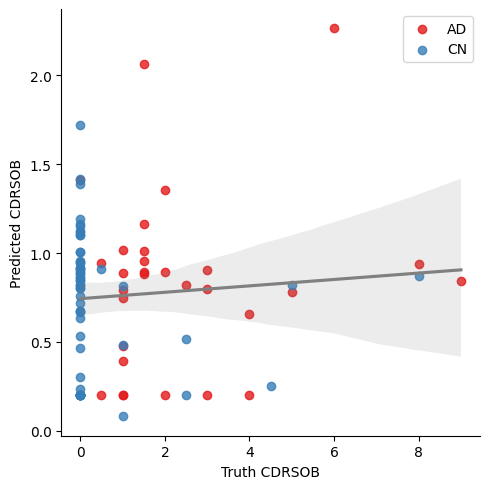

In [31]:
if flag_MMSE or flag_MMSE_Scaled: TITLE = "MMSE"
elif flag_CDR or flag_CDR_Scaled: TITLE = "CDR"
elif flag_CDRSOB or flag_CDRSOB_Scaled: TITLE = "CDRSOB"

result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth '+TITLE] = result_ground_truth
result_df['Predicted '+TITLE] = result_prediction

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth '+TITLE], result_df['Predicted '+TITLE])

hue_order = ['AD', 'CN']
sns.lmplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
# if flag_MMSE or flag_MMSE_Scaled:
#     ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
#     ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
# elif flag_CDR or flag_CDR_Scaled:
#     ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
#     ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
# elif flag_CDRSOB or flag_CDRSOB_Scaled:
#     ax.set_xticks([0, 2, 4, 6, 8])
#     ax.set_yticks([0, 2, 4, 6, 8])  
ax.legend()

# Stand-to-Sit

## Load Coordinate Data

In [32]:
def load_coordinate_data(trainID, valID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxVal_5f, xVal_5f, yVal_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []
    
    for fold_idx in range(n_FOLD):
        idxTrain, xTrain, yTrain = [], [], []
        idxVal, xVal, yVal = [], [], []
        idxTest, xTest, yTest = [], [], []

        train_index = trainID[fold_idx]
        val_index = valID[fold_idx]
        test_index = testID[fold_idx]

        for pid in train_index: ### ===================================== Train =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_stand2sit_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]

                idxTrain.append(int(pid))
                xTrain.append(xData)
                yTrain.append(yLabel)
        
        for pid in val_index: ### ===================================== Validation =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_stand2sit_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]

                idxVal.append(int(pid))
                xVal.append(xData)
                yVal.append(yLabel)
        
        for pid in test_index: ### ===================================== Test =====================================
            csv_path = KeypointsROOT + pid + '/Sit-and-Stand_20240314/' + pid + '_7_stand2sit_timeSeries_resampling.csv'
            if not os.path.exists(csv_path):
                print(f'{pid} time series data CSV does not exit.')
            else:
                df = pd.read_csv(csv_path, header=None)
                n_feature, n_timestamp = df.shape[0], df.shape[1]
                data = df.values
                xData = data.reshape(n_feature, n_timestamp).tolist()
                # yLabel = Label_dict[int(pid)]
                if flag_MMSE: yLabel = MMSE_dict[int(pid)]
                elif flag_MMSE_Scaled: yLabel = MMSE_dict_scaled[int(pid)]
                elif flag_CDR: yLabel = CDR_dict[int(pid)]
                elif flag_CDR_Scaled: yLabel = CDR_dict_scaled[int(pid)]
                elif flag_CDRSOB: yLabel = CDRSOB_dict[int(pid)]
                elif flag_CDRSOB_Scaled:  yLabel = CDRSOB_dict_scaled[int(pid)]
                
                idxTest.append(int(pid))
                xTest.append(xData)
                yTest.append(yLabel)

        idxTrain_5f.append(np.array(idxTrain))
        xTrain_5f.append(np.array(xTrain))
        yTrain_5f.append(np.array(yTrain))
        idxVal_5f.append(np.array(idxVal))
        xVal_5f.append(np.array(xVal))
        yVal_5f.append(np.array(yVal))
        idxTest_5f.append(np.array(idxTest))
        xTest_5f.append(np.array(xTest))
        yTest_5f.append(np.array(yTest))
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxVal_5f, xVal_5f, yVal_5f, idxTest_5f, xTest_5f, yTest_5f


idxTrain_5f_Stand2Sit, xTrain_5f_Stand2Sit, yTrain_5f_Stand2Sit, \
    idxVal_5f_Stand2Sit, xVal_5f_Stand2Sit, yVal_5f_Stand2Sit, \
        idxTest_5f_Stand2Sit, xTest_5f_Stand2Sit, yTest_5f_Stand2Sit = load_coordinate_data(trainID_5f, validateID_5f, testID_5f)

In [33]:
print(f'-------------------- Stand-to-Sit ---------------')
for fold_idx in range(n_FOLD):
    idxTest_5f_Stand2Sit[fold_idx] = np.array(idxTest_5f_Stand2Sit[fold_idx])
    xTest_5f_Stand2Sit[fold_idx] = np.array(xTest_5f_Stand2Sit[fold_idx])
    yTest_5f_Stand2Sit[fold_idx] = np.array(yTest_5f_Stand2Sit[fold_idx])
    print(f'- [Fold {fold_idx+1}] idxTest: {idxTest_5f_Stand2Sit[fold_idx].shape}, xTest: {xTest_5f_Stand2Sit[fold_idx].shape}, yTest: {yTest_5f_Stand2Sit[fold_idx].shape}')

-------------------- Stand-to-Sit ---------------
- [Fold 1] idxTest: (18,), xTest: (18, 13, 29), yTest: (18,)
- [Fold 2] idxTest: (18,), xTest: (18, 13, 29), yTest: (18,)
- [Fold 3] idxTest: (18,), xTest: (18, 13, 29), yTest: (18,)
- [Fold 4] idxTest: (17,), xTest: (17, 13, 29), yTest: (17,)
- [Fold 5] idxTest: (17,), xTest: (17, 13, 29), yTest: (17,)


In [34]:
for i in range(n_FOLD):
    ### ========================= [Stand2Sit] Train =========================
    tmpIdx = np.array(idxTrain_5f_Stand2Sit[i])
    tmpX = np.array(xTrain_5f_Stand2Sit[i])
    tmpY = np.array(yTrain_5f_Stand2Sit[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxTrain_5f_Stand2Sit[i] = tmpIdx
    xTrain_5f_Stand2Sit[i] = tmpX
    yTrain_5f_Stand2Sit[i] = tmpY
    
    ### ========================= [Stand2Sit] Train =========================
    tmpIdx = np.array(idxVal_5f_Stand2Sit[i])
    tmpX = np.array(xVal_5f_Stand2Sit[i])
    tmpY = np.array(yVal_5f_Stand2Sit[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxVal_5f_Stand2Sit[i] = tmpIdx
    xVal_5f_Stand2Sit[i] = tmpX
    yVal_5f_Stand2Sit[i] = tmpY
    
    ### ========================= [Stand2Sit] Test =========================
    tmpIdx = np.array(idxTest_5f_Stand2Sit[i])
    tmpX = np.array(xTest_5f_Stand2Sit[i])
    tmpY = np.array(yTest_5f_Stand2Sit[i])
    tmpIdx, tmpX, tmpY = shuffle(tmpIdx, tmpX, tmpY)
    idxTest_5f_Stand2Sit[i] = tmpIdx
    xTest_5f_Stand2Sit[i] = tmpX
    yTest_5f_Stand2Sit[i] = tmpY

    
print(f'-------------------- Stand-to-Sit ---------------')
print(f'[Input Data] / [Target Data]')
for i in range(n_FOLD):
    print(f'- [Fold {i+1}] Train: {xTrain_5f_Stand2Sit[i].shape},  {yTrain_5f_Stand2Sit[i].shape}')
    print(f'-          Val:   {xVal_5f_Stand2Sit[i].shape},  {yVal_5f_Stand2Sit[i].shape}')
    print(f'-          Test:  {xTest_5f_Stand2Sit[i].shape},  {yTest_5f_Stand2Sit[i].shape}')

-------------------- Stand-to-Sit ---------------
[Input Data] / [Target Data]
- [Fold 1] Train: (56, 13, 29),  (56,)
-          Val:   (14, 13, 29),  (14,)
-          Test:  (18, 13, 29),  (18,)
- [Fold 2] Train: (56, 13, 29),  (56,)
-          Val:   (14, 13, 29),  (14,)
-          Test:  (18, 13, 29),  (18,)
- [Fold 3] Train: (56, 13, 29),  (56,)
-          Val:   (14, 13, 29),  (14,)
-          Test:  (18, 13, 29),  (18,)
- [Fold 4] Train: (56, 13, 29),  (56,)
-          Val:   (15, 13, 29),  (15,)
-          Test:  (17, 13, 29),  (17,)
- [Fold 5] Train: (56, 13, 29),  (56,)
-          Val:   (15, 13, 29),  (15,)
-          Test:  (17, 13, 29),  (17,)


## Training

### Train & Save models

In [35]:
n_PERIOD = 29

n_MODEL = 3

# MAX_EPOCHS = 15
MAX_EPOCHS = 20
BATCH_SIZE = 4
Threshold = 0.5

best_threshold_5f_sit2stand_List = []
best_f1score_5f_sit2stand_List = []

In [36]:
best_threshold_5f_List_Stand2Sit = []
best_f1score_5f_List_Stand2Sit = []

def show_training_loss_and_accuracy(history):
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Training accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.legend()
    plt.show()


def training_model_Validation_data_Save_model():
    idxTrain_5f, xTrain_5f, yTrain_5f = idxTrain_5f_Stand2Sit, xTrain_5f_Stand2Sit, yTrain_5f_Stand2Sit
    idxVal_5f, xVal_5f, yVal_5f = idxVal_5f_Stand2Sit, xVal_5f_Stand2Sit, yVal_5f_Stand2Sit
    
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxVal_5f[fold_idx], xVal_5f[fold_idx], yVal_5f[fold_idx]

        xTrain_1f = xTrain_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) ### shape = (n_samples, 13, 7, 1)
        xVal_1f = xVal_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)

        print(f'[Stand-to-Sit] Training for [Fold {fold_idx+1}] ...')

        if flag_PreTrained==False:
            model = Sequential()
            model.add(Conv2D(2, kernel_size=(1, 4), activation='relu', strides=1, padding='SAME', input_shape=(int(n_FEATURE), int(n_PERIOD), 1), name='first_conv')) ### grayscale image
            model.add(Conv2D(2, kernel_size=(1, 4), activation='relu', strides=1, name='last_conv')) 
            model.add(Dropout(0.2))
            model.add(Flatten())
            model.add(Dense(8, activation='relu', kernel_regularizer=l1(0.00005)))
            model.add(Dropout(0.1))
            model.add(Dense(1, activation='linear'))

        elif flag_PreTrained==True:
            LOAD_PRETRAINED = "../Sit-Stand Subtask/LOG/10/Model_Weights/"
            pretrained_model = load_model(f"{LOAD_PRETRAINED}stand2sit_model_Fold{fold_idx+1}.h5")
            for layer in pretrained_model.layers[:-3]:
                layer.trainable = False
            x = pretrained_model.layers[-4].output
            x = Dense(32, activation='relu', kernel_regularizer=l1(0.00005))(x)
            x = Dropout(0.5)(x)
            outputs = Dense(1, activation='linear')(x)
            model = Model(inputs=pretrained_model.input, outputs=outputs)
            
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

        history = model.fit(xTrain_1f, yTrain_1f, 
                            epochs=MAX_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(xVal_1f, yVal_1f), 
                            shuffle=True, verbose=0)

        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVEMODEL_FOLDER):
            os.makedirs(SAVEMODEL_FOLDER)
        model.save(f'{SAVEMODEL_FOLDER}stand2sit_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(model.summary())

training_model_Validation_data_Save_model()

[Stand-to-Sit] Training for [Fold 1] ...
[Stand-to-Sit] Training for [Fold 2] ...
[Stand-to-Sit] Training for [Fold 3] ...
[Stand-to-Sit] Training for [Fold 4] ...
[Stand-to-Sit] Training for [Fold 5] ...
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_input (InputLayer [(None, 13, 29, 1)]       0         
_________________________________________________________________
first_conv (Conv2D)          (None, 13, 29, 2)         10        
_________________________________________________________________
last_conv (Conv2D)           (None, 13, 26, 2)         18        
_________________________________________________________________
dropout_58 (Dropout)         (None, 13, 26, 2)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 676)               0         
____________________________________________________

## Evaluate

In [37]:
if flag_PreTrained==True:
    if flag_MMSE: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: LOAD_MODEL_FOLDER = "LOG_SiLOG_SitStand_PreTrainedtStand/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: LOAD_MODEL_FOLDER = "LOG_SitStand_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_SitStand_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [38]:
score_stand2sit_of_each_pid = {}

result_label = []
result_ground_truth = []
result_prediction = []


def analyze_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        
        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB: groundTruth = CDRSOB_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        prediction = score / nPairs
        
        score_stand2sit_of_each_pid[pid] = {}
        score_stand2sit_of_each_pid[pid]["Label"] = label
        score_stand2sit_of_each_pid[pid]["Prediction"] = prediction
        score_stand2sit_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_prediction.append(prediction)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {prediction}')


def analyze_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]

        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB: groundTruth = CDRSOB_dict[pid]
        
        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            avgScore = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            avgScore = np.average(tmp_score_list, weights=tmp_score_list)
        
        score_stand2sit_of_each_pid[pid] = {}
        score_stand2sit_of_each_pid[pid]["Label"] = label
        score_stand2sit_of_each_pid[pid]["Prediction"] = avgScore
        score_stand2sit_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_prediction.append(avgScore)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')
        
def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}stand2sit_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f_Stand2Sit[fold_idx], xTest_5f_Stand2Sit[fold_idx], yTest_5f_Stand2Sit[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        # print(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        # analyze_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        analyze_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold

rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

In [39]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [2.62, 1.62, 2.26, 1.38, 1.82]
(2) MSE: [6.87, 2.62, 5.13, 1.91, 3.31]
(3) MAE: [1.48, 1.03, 1.58, 1.16, 1.2]


In [40]:
score_stand2sit_of_each_pid

{1: {'Label': 0, 'Prediction': 0.33026105, 'Groud Truth': 0.0},
 2: {'Label': 0, 'Prediction': 1.0338954, 'Groud Truth': 0.0},
 4: {'Label': 1, 'Prediction': 1.0586896, 'Groud Truth': 1.5},
 11: {'Label': 1, 'Prediction': 0.9195885, 'Groud Truth': 9.0},
 29: {'Label': 0, 'Prediction': 1.0735021, 'Groud Truth': 0.0},
 34: {'Label': 0, 'Prediction': 0.9611326, 'Groud Truth': 0.0},
 36: {'Label': 1, 'Prediction': 1.3683702, 'Groud Truth': 8.0},
 37: {'Label': 1, 'Prediction': 1.2433958, 'Groud Truth': 1.5},
 44: {'Label': 0, 'Prediction': 1.2313273, 'Groud Truth': 0.0},
 45: {'Label': 1, 'Prediction': 1.3911304, 'Groud Truth': 1.5},
 49: {'Label': 0, 'Prediction': 1.9674754, 'Groud Truth': 0.0},
 59: {'Label': 1, 'Prediction': 1.1697793, 'Groud Truth': 1.0},
 67: {'Label': 0, 'Prediction': 0.7513112, 'Groud Truth': 0.5},
 75: {'Label': 0, 'Prediction': 1.5836504, 'Groud Truth': 0.0},
 81: {'Label': 0, 'Prediction': 1.6167717, 'Groud Truth': 0.0},
 83: {'Label': 0, 'Prediction': 0.16411868

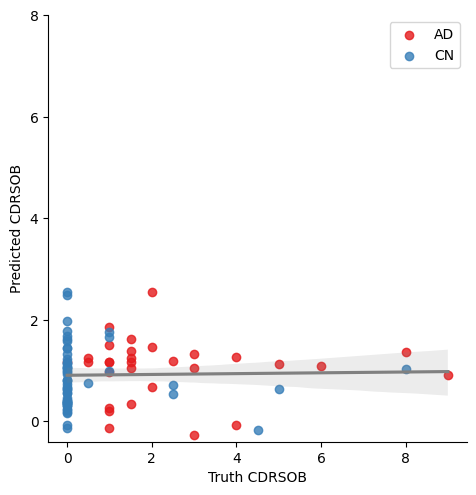

In [41]:
if flag_MMSE or flag_MMSE_Scaled: TITLE = "MMSE"
elif flag_CDR or flag_CDR_Scaled: TITLE = "CDR"
elif flag_CDRSOB or flag_CDRSOB_Scaled: TITLE = "CDRSOB"

result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth '+TITLE] = result_ground_truth
result_df['Predicted '+TITLE] = result_prediction

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth '+TITLE], result_df['Predicted '+TITLE])

hue_order = ['AD', 'CN']
sns.lmplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

if flag_MMSE or flag_MMSE_Scaled:
    ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
if flag_CDR or flag_CDR_Scaled:
    ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
if flag_CDRSOB or flag_CDRSOB_Scaled:
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_yticks([0, 2, 4, 6, 8])  

ax.legend()

# Combine

In [42]:
score_combined_of_each_pid = {}

result_label = []
result_ground_truth = []
result_prediction = []


for pid in allID_list:
    pid = int(pid)
    label = score_sit2stand_of_each_pid[pid]['Label']
    score1 = score_sit2stand_of_each_pid[pid]['Prediction']
    score2 = score_stand2sit_of_each_pid[pid]['Prediction']
    ground_truth = score_sit2stand_of_each_pid[pid]['Groud Truth']
    score = (score1+score2)/2

    score_combined_of_each_pid[pid] = {}
    score_combined_of_each_pid[pid]['Prediction'] = score
    score_combined_of_each_pid[pid]['Score1'] = score1
    score_combined_of_each_pid[pid]['Score2'] = score2
    score_combined_of_each_pid[pid]['Label'] = label
    score_combined_of_each_pid[pid]['Ground_Truth'] = ground_truth

    if label==0: label="Non-AD"
    elif label==1: label="AD"
    result_label.append(label)
    result_ground_truth.append(ground_truth)
    result_prediction.append(score)


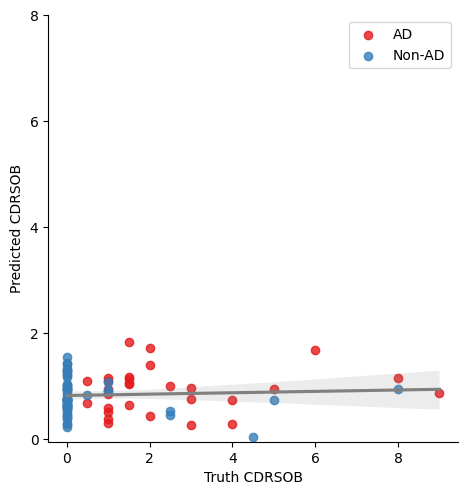

In [43]:
if flag_MMSE or flag_MMSE_Scaled: TITLE = "MMSE"
elif flag_CDR or flag_CDR_Scaled: TITLE = "CDR"
elif flag_CDRSOB or flag_CDRSOB_Scaled: TITLE = "CDRSOB"

result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth '+TITLE] = result_ground_truth
result_df['Predicted '+TITLE] = result_prediction

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth '+TITLE], result_df['Predicted '+TITLE])

hue_order = ['AD', 'Non-AD']
sns.lmplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})

if flag_MMSE or flag_MMSE_Scaled:
    ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
elif flag_CDR or flag_CDR_Scaled:
    ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
elif flag_CDRSOB or flag_CDRSOB_Scaled:
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_yticks([0, 2, 4, 6, 8])  

ax.legend()

# Write to CSV file

In [44]:
score_combined_of_each_pid_sorted = {}

keys = list(score_combined_of_each_pid.keys())
keys.sort()
score_combined_of_each_pid_sorted = {i: score_combined_of_each_pid[i] for i in keys}

score_combined_of_each_pid_sorted[1]

{'Prediction': 0.715965747833252,
 'Score1': 1.1016704,
 'Score2': 0.33026105,
 'Label': 0,
 'Ground_Truth': 0.0}

In [45]:
def write_result_to_csv(data_dict, fileName):
    result_list = []
    for key in data_dict:
        pid = key
        prediction = data_dict[key]['Prediction']
        score1 = data_dict[key]['Score1']
        score2 = data_dict[key]['Score2']
        label = data_dict[key]['Label']
        ground_truth = data_dict[key]['Ground_Truth']
        result_list.append([pid, prediction, score1, score2, label, ground_truth])
        
    field_name = ['Pid', 'Prediction', 'Score_Sit2Stand', 'Score_Stand2Sit', 'Label', 'Ground_Truth']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)


if flag_PreTrained==False:
    if flag_MMSE: filename = "Results/SitStand_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/SitStand_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/SitStand_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/SitStand_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/SitStand_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/SitStand_CDRSOB_Scaled.csv"
if flag_PreTrained==True:
    if flag_MMSE: filename = "Results/SitStand_PreTrained_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/SitStand_PreTrained_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/SitStand_PreTrained_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/SitStand_PreTrained_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/SitStand_PreTrained_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/SitStand_PreTrained_CDRSOB_Scaled.csv"

write_result_to_csv(score_combined_of_each_pid_sorted, filename)
score_combined_of_each_pid_sorted

{1: {'Prediction': 0.715965747833252,
  'Score1': 1.1016704,
  'Score2': 0.33026105,
  'Label': 0,
  'Ground_Truth': 0.0},
 2: {'Prediction': 1.0200824737548828,
  'Score1': 1.0062696,
  'Score2': 1.0338954,
  'Label': 0,
  'Ground_Truth': 0.0},
 3: {'Prediction': 0.6499531269073486,
  'Score1': 0.6337729,
  'Score2': 0.6661333,
  'Label': 0,
  'Ground_Truth': 0.0},
 4: {'Prediction': 1.0351132154464722,
  'Score1': 1.0115368,
  'Score2': 1.0586896,
  'Label': 1,
  'Ground_Truth': 1.5},
 5: {'Prediction': 0.9047303795814514,
  'Score1': 0.8121232,
  'Score2': 0.9973376,
  'Label': 0,
  'Ground_Truth': 1.0},
 6: {'Prediction': 1.3438615798950195,
  'Score1': 0.20310643,
  'Score2': 2.4846168,
  'Label': 0,
  'Ground_Truth': 0.0},
 7: {'Prediction': 0.6006506681442261,
  'Score1': 0.8056104,
  'Score2': 0.39569086,
  'Label': 0,
  'Ground_Truth': 0.0},
 9: {'Prediction': 1.6753721237182617,
  'Score1': 2.2631261,
  'Score2': 1.0876181,
  'Label': 1,
  'Ground_Truth': 6.0},
 10: {'Predict